Note: Make sure to set the runtime type on GPU mood before you start!

## Importing Needed Modules

In [1]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
import shutil

## Importing Dataset and preprocessing

The dataset which is used in this project is downloaded from [here](https://www.dukascopy.com/plugins/fxMarketWatch/?historical_data). This dataset contains Open price, High price, Low price, Close price, and volume of XAUUSD trading in the 5-minute time frame from 1st January 2022 until 6th August 2022 (the day of doing the project).

In order to use the given dataset, you need to download it and put it in the desired directory. As I was working on Colab, I put the dataset on my drive and imported it to the environment from there. Pay attention to the `data_dir` variable in the following code cell and set it in a way that is proper for your

In [2]:
data_dir = '/content/drive/MyDrive/XAUUSD_Candlestick_5_M_BID_01.01.2022-06.08.2022.csv'
df = pd .read_csv(data_dir)

Now let's take a look at the raw dataset!

In [3]:
print(df.shape)
df.head()

(62772, 6)


,Local time,Open,High,Low,Close,Volume
0,01.01.2022 00:00:00.000 GMT+0330,1828.478,1828.624,1828.434,1828.514,40399.9994
1,01.01.2022 00:05:00.000 GMT+0330,1828.514,1829.054,1828.468,1828.984,58690.0013
2,01.01.2022 00:10:00.000 GMT+0330,1828.984,1829.128,1828.718,1828.964,29900.0003
3,01.01.2022 00:15:00.000 GMT+0330,1828.964,1829.608,1828.934,1829.528,53070.0003
4,01.01.2022 00:20:00.000 GMT+0330,1829.554,1830.248,1829.454,1829.898,75590.0014


As it is obvious, there are 62772 rows in the dataset each of which shows a particular trading position in the 5-minute time frame. But there are some rows the volume of which is 0 which means there was no trading action at that moment. These 0-volume rows are indicating when the market is closed (weekends) or is on its daily break. to make the dataset clean, I eliminated these 0-volume rows and only used values when the market was actively working.

In [4]:
new_df = df[df['Volume'] != 0]
print(new_df.shape)
new_df.head()

(42354, 6)


,Local time,Open,High,Low,Close,Volume
0,01.01.2022 00:00:00.000 GMT+0330,1828.478,1828.624,1828.434,1828.514,40399.9994
1,01.01.2022 00:05:00.000 GMT+0330,1828.514,1829.054,1828.468,1828.984,58690.0013
2,01.01.2022 00:10:00.000 GMT+0330,1828.984,1829.128,1828.718,1828.964,29900.0003
3,01.01.2022 00:15:00.000 GMT+0330,1828.964,1829.608,1828.934,1829.528,53070.0003
4,01.01.2022 00:20:00.000 GMT+0330,1829.554,1830.248,1829.454,1829.898,75590.0014


I only used the close prices for price prediction. Thus, I separated these values from the dataset and made an array of them.

In [5]:
inp_arr = np.array(new_df['Close'])

print('Shape:', np.shape(inp_arr))

Shape: (42354,)


Now it is time to prepare the dataset in a way that is proper for training my model. To achieve this objective, I created a function that can chop the dataset values into the inputs and labels.

In [6]:
def windowed_dataset(series, window_size, prediction_window, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + prediction_window, shift = 1, drop_remainder = True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + prediction_window))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-prediction_window], window[-prediction_window:]))
  dataset = dataset.batch(batch_size).prefetch(1)

  return dataset

It is expected that `windowed_dataset` convert a given array like `([[1],[2],[3],[4],[5]])` into `([[1],[2],[3],[4]],[[5]])` that the first part `[[1],[2],[3],[4]]` is considered as the input and `[[5]]` is the label of that. Let's make sure if it is working properly!

In [7]:
sample_arr = np.array([[1],[2],[3],[4],[5]])

a = windowed_dataset(sample_arr, window_size = 4, prediction_window = 1, batch_size = 32, shuffle_buffer = 10)

for i in a:
  print(i)

(<tf.Tensor: shape=(1, 4, 1), dtype=int64, numpy=
array([[[1],
        [2],
        [3],
        [4]]])>, <tf.Tensor: shape=(1, 1, 1), dtype=int64, numpy=array([[[5]]])>)


Before feeding the `inp_arr` into the `windowed_dataset`, we need to split the dataset into train and validation sets. the first 80% of the dataset is used as the training set and the other 20% of that is used as validation set.

Note that I set `window_size` to 100 and `prediction_window` to 1 which means the model has to predict the close price of a given position by analyzing the last 100 close prices before that specific price.

In [8]:
split_time = int(0.8*len(inp_arr))
print('split time is:',split_time)

x_train = inp_arr[:split_time] 
x_valid = inp_arr[split_time:] 

print('shape of x_train',np.shape(x_train))
print('shape of x_valid',np.shape(x_valid))

window_size = 100
prediction_window = 1
batch_size = 32
shuffle_buffer = 50000

split time is: 33883
shape of x_train (33883,)
shape of x_valid (8471,)


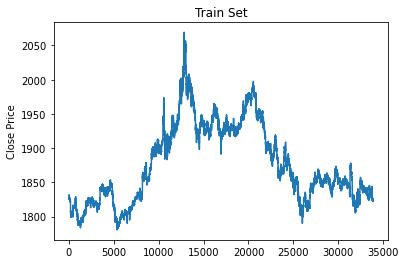

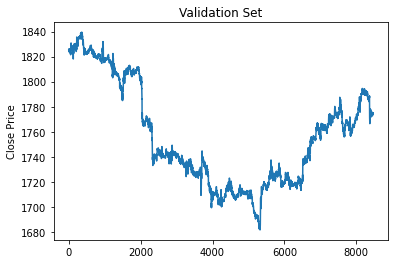

In [9]:
# Train and validation set visualization

plt.plot(x_train)
plt.title('Train Set')
plt.ylabel('Close Price')
plt.figure()
plt.plot(x_valid)
plt.title('Validation Set')
plt.ylabel('Close Price')
plt.show()

I used standardization method to make values in the train set being 0-mean. 

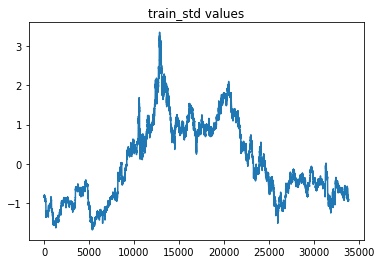

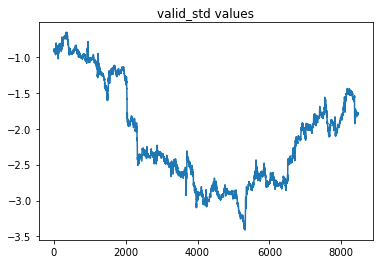

In [10]:
std_scaler = StandardScaler()
x_train_std = std_scaler.fit_transform(np.expand_dims(x_train, axis=-1))
x_valid_std = std_scaler.transform(np.expand_dims(x_valid, axis=-1))

plt.plot(x_train_std)
plt.title('train_std values')
plt.figure()
plt.plot(x_valid_std)
plt.title('valid_std values')
plt.show()

In [11]:
dataset = windowed_dataset(x_train_std, window_size = window_size, prediction_window = prediction_window
                           , batch_size = batch_size,shuffle_buffer = shuffle_buffer)

Great! The dataset is completely ready to be fed into the model.

## Model Structure

In [12]:
def biLSTM_model():
    model = tf.keras.models.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(300,return_sequences=True,kernel_initializer='he_normal'),input_shape=(100 , 1)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(200 ,return_sequences=True,kernel_initializer = 'he_normal')),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100 ,return_sequences=True,kernel_initializer = 'he_normal')),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50 ,return_sequences=True,kernel_initializer = 'he_normal')),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(25,activation = 'selu',kernel_initializer = 'he_normal')),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1)    
])
    return model

In [13]:
model = biLSTM_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 100, 600)         724800    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 100, 400)         1281600   
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 100, 200)         400800    
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 100, 100)         100400    
 nal)                                                            
                                                                 
 dropout (Dropout)           (None, 100, 100)          0

## Training Model

In [14]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001) , loss='mae')

In [15]:
history = model.fit(dataset, epochs = 100)

Epoch 1/100
1056/1056 [==============================] - 67s 45ms/step - loss: 0.0977
Epoch 2/100
1056/1056 [==============================] - 52s 46ms/step - loss: 0.0363
Epoch 3/100
1056/1056 [==============================] - 53s 46ms/step - loss: 0.0312
Epoch 4/100
1056/1056 [==============================] - 52s 46ms/step - loss: 0.0298
Epoch 5/100
1056/1056 [==============================] - 52s 46ms/step - loss: 0.0271
Epoch 6/100
1056/1056 [==============================] - 54s 46ms/step - loss: 0.0258
Epoch 7/100
1056/1056 [==============================] - 53s 46ms/step - loss: 0.0257
Epoch 8/100
1056/1056 [==============================] - 53s 46ms/step - loss: 0.0236
Epoch 9/100
1056/1056 [==============================] - 53s 46ms/step - loss: 0.0232
Epoch 10/100
1056/1056 [==============================] - 53s 46ms/step - loss: 0.0223
Epoch 11/100
1056/1056 [==============================] - 53s 46ms/step - loss: 0.0220
Epoch 12/100
1056/1056 [============================

It can be beneficial if we take a look at the loss value changes

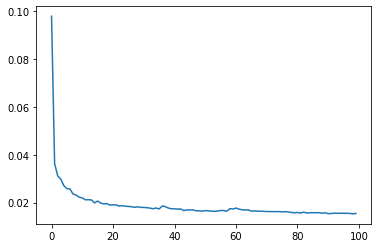

In [16]:
plt.plot(history.history['loss'])

## Results

In [17]:
# Chopping valid data

valid_dataset =  windowed_dataset(x_valid_std, window_size = window_size, prediction_window = prediction_window
                           , batch_size = batch_size,shuffle_buffer = shuffle_buffer)

We can evaluate the performance of our model on the validation dataset.

In [18]:
model.evaluate(valid_dataset)

262/262 [==============================] - 9s 20ms/step - loss: 0.1198


0.11976853758096695

The loss value for the valid set is much higher than its value for the train set. (0.1198 for valid and 0.0155 for train) It means that our model is overfitted and some actions must be done to address this problem. For instance, gathering more data or training the model for more epochs can be helpful. However, I will continue this overfitting model to the end to see the final results. Thus, in the next step, I predict the valid values with the prepared model.

In [19]:
aa = []
for i in tqdm(range(len(x_valid_std)-100)): #as the first 100 values are used for predicting the first predicted value
  a = model.predict(np.reshape(x_valid_std[i:i+100], (1,100)))

  aa.append(std_scaler.inverse_transform(a))

100%|██████████| 8371/8371 [09:21<00:00, 14.91it/s]


In [21]:
np.shape(aa)
results = np.reshape(aa, (8371,))
np.shape(results)

(8371,)

Now, the predicted values are ready and we can create a data frame containing both real and predicted values in order to compare them and find if they are close enough.

In [24]:
tmp_df = pd.DataFrame()
tmp_df['x_valid'] = list(x_valid[100:])                           # real values column
tmp_df['predicted'] = results                                     # predicted values column
tmp_df['diff'] = np.abs(tmp_df['x_valid'] - tmp_df['predicted'])  # the difference between real and predicted values column
tmp_df.head()

,x_valid,predicted,diff
0,1825.093,1826.912109,1.819109
1,1825.393,1825.723022,0.330022
2,1825.708,1826.001587,0.293587
3,1825.718,1826.138184,0.420184
4,1825.678,1826.152100,0.474100


The data frame above shows that the model is performing perfectly in some cases and makes very few errors (for example row 2 has less than 3 pips error!). Although it is working poorly in some other cases. to have a comprehensive insight into how our model is performing, it can be advantageous to plot real and predicted values simultaneously.

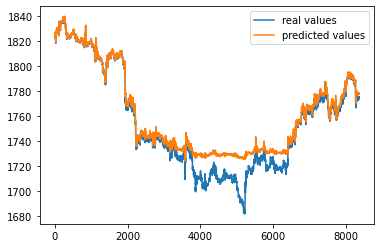

In [35]:
plt.plot(tmp_df['x_valid'], label = 'real values')
plt.plot(tmp_df['predicted'],  label = 'predicted values')
plt.legend()
plt.show()

Wow! what a chart!

This chart proves that the model is working properly in values that are closer to the train values (left part of the chart) and is getting worse as it gets farther than train values. It can be inferred that for better performance in farther values (right part of the chart) we need to retrain the model with a new train dataset which is a combination of the former train set and the left part of the validation dataset.

To have a specific metric for assessment, I calculate the mean absolute percentage error. One for the whole dataset and another one for the values in the left part of the chart above (first 2000 values in the valid set!)

In [31]:
mape = tf.keras.metrics.mean_absolute_percentage_error(np.array(tmp_df['x_valid']), np.array(tmp_df['predicted'])).numpy()
l_mape = tf.keras.metrics.mean_absolute_percentage_error(np.array(tmp_df['x_valid'])[:2000], np.array(tmp_df['predicted'])[:2000]).numpy()

print('mean absolute percentage error for the whole validation set is:', mape)
print('mean absolute percentage error for the first values in the validation set is:', l_mape)

mean absolute percentage error for the whole validation set is: 0.3991188
mean absolute percentage error for the first values in the validation set is: 0.045492448


To sum up, the model trained here can predict the values near the training dataset very well! 

However, it does not mean that this model is a tool for real trading and everyone must take care of his considerations.